In [1]:
using Pkg
Pkg.activate("../Tambo/")
using Tambo
using JLD2
using StatsBase
using Plots

  Activating project at `/n/holylfs05/LABS/arguelles_delgado_lab/Lab/common_software/source/TAMBO-MC/Tambo`


ArgumentError: ArgumentError: Package Plots not found in current path.
- Run `import Pkg; Pkg.add("Plots")` to install the Plots package.

In [2]:
TAMBO_PATH = "../Tambo"
# This should be the simulation parameters jld2 file
SIMULATION_FILE = "/n/holylfs05/LABS/arguelles_delgado_lab/Lab/common_software/source/corsika8/corsika-work/Oct16th2023_WhitePaper_300k.jld2"

"/n/holylfs05/LABS/arguelles_delgado_lab/Lab/common_software/source/corsika8/corsika-work/Oct16th2023_WhitePaper_300k.jld2"

In [3]:
sim = jldopen(SIMULATION_FILE)
config = SimulationConfig(; geo_spline_path="/n/home02/thomwg11/tambo/TAMBO-MC/resources/tambo_spline.jld2", filter(x->x[1]!=:geo_spline_path, sim["config"])...)
geo = Tambo.Geometry(config)
injector = Tambo.Injector(config);

In [2]:
triggered_events_white_paper = load("/n/home02/thomwg11/tambo/TAMBO-MC/scripts/2_trigger_events/triggered_events_whitepaper_mod_3_event_30.jld2")["triggered_events"]
triggered_events_three_amigos = load("/n/home02/thomwg11/tambo/TAMBO-MC/scripts/2_trigger_events/triggered_events_threeamigos_mod_3_event_30.jld2")["triggered_events"]
triggered_events_icetop_tanks = load("/n/home02/thomwg11/tambo/TAMBO-MC/scripts/2_trigger_events/triggered_events_icetop_tanks_mod_300_event_3000.jld2")["triggered_events"]
triggered_events_icetop_panels = load("/n/home02/thomwg11/tambo/TAMBO-MC/scripts/2_trigger_events/triggered_events_icetop_panels_mod_195_event_1950.jld2")["triggered_events"];

In [3]:
triggered_events_white_paper

526-element Vector{Tambo.InjectionEvent}:
 Tambo.InjectionEvent(Particle(pdg_mc=16, energy=1.847810414616308e6 GeV, position=[22624.051128958363, -11244.03631965433, -2117.4289362862182]m, direction=(83.2°, 152.0°)), Particle(pdg_mc=16, energy=1.847810414616308e6 GeV, position=[22624.051128958363, -11244.03631965433, -2117.4289362862182]m, direction=(83.2°, 152.0°)), Particle(pdg_mc=15, energy=1.6100558311411885e6 GeV, position=[4407.502595143837, -1612.493351598705, 342.82259779471394]m, direction=(83.2°, 152.0°)), 2.3597899134678228e28, 2.3597899134678228e28)
 Tambo.InjectionEvent(Particle(pdg_mc=16, energy=2.6454409594586387e7 GeV, position=[402.74258555046293, -11244.03631965433, -603.7052559712366]m, direction=(87.8°, 94.7°)), Particle(pdg_mc=16, energy=2.6454409594586387e7 GeV, position=[402.74258555046293, -11244.03631965433, -603.7052559712366]m, direction=(87.8°, 94.7°)), Particle(pdg_mc=15, energy=2.3043527702212606e7 GeV, position=[-157.59992360185063, -4439.460837754127, -3

In [4]:
function calc_triggered_event_rate(triggered_events)
    γ = 2.52
    norm = 1.8e-18 / units.GeV / units.cm^2 / units.second * (1 /(100units.TeV))^-γ
    pl = Tambo.PowerLaw(γ, 100units.GeV, 1e9units.GeV, norm)
    fluxes = pl.(triggered_events["initial_state"]["energy"])
    wgts = oneweight.(triggered_events, Ref(injector), Ref(injector.xs)) ./ 70000 # FIXME hack
    #wgts = oneweight.(triggered_events, Ref(injector), Ref(injector.xs)) ./ 20000
    global_fit_rates = fluxes .* wgts
    return global_fit_rates
end

calc_triggered_event_rate (generic function with 1 method)

In [18]:
rates_white_paper = calc_triggered_event_rate(triggered_events_white_paper)
rates_three_amigos = calc_triggered_event_rate(triggered_events_three_amigos)
rates_icetop_tanks = calc_triggered_event_rate(triggered_events_icetop_tanks)
rates_icetop_panels = calc_triggered_event_rate(triggered_events_icetop_panels)

events_per_year_wp = sum(rates_white_paper) * 1 * (5000/400) * 3 * 10^7.5 * units.second
events_per_year_ta = sum(rates_three_amigos) * 1 * (5000/400) * 3 * 10^7.5 * units.second
events_per_year_it_tanks = sum(rates_icetop_tanks) * 1 * (5000/400) * 3 * 10^7.5 * units.second
events_per_year_it_panels = sum(rates_icetop_panels) * 1 * (5000/400) * 3 * 10^7.5 * units.second

println("White paper: $(events_per_year_wp)")
println("Three amigos: $(events_per_year_ta)")
println("IceTop Tanks: $(events_per_year_it_tanks)")
println("IceTop Panels: $(events_per_year_it_panels)")

White paper: 1.0322423578488351
Three amigos: 1.0186206520540297
IceTop Tanks: 0.37398310840826293
IceTop Panels: 0.8914802476209089


In [43]:
rates_three_amigos ./ fluxes 

518-element Vector{Float64}:
    0.022036062596067125
   13.625039159882208
   15.014443471534952
    5.289950543690144
    9.917693621228015
   85.12435196353421
  267.06623836493304
  399.7732317305091
    1.2689400475757027
   16.592421232203364
    0.32650184081942407
    0.7324014478542986
   64.0176382907052
    ⋮
  188.5885234507393
 2527.29583885192
   59.02785402613034
    0.08393309654614552
    7.128736967524058
  191.91693739947883
   97.18694464567945
   82.37159357183283
   34.18396105963942
    0.01760619954069927
    0.02353053026989064
   12.844184120269526

In [64]:
hist_three.weights ./ diff(edges) ./units.m^2 .* (5_000 / nmodules) 

8-element Vector{Float64}:
     0.0
     0.0
   116.92318065348452
  1060.1706272399356
  4543.997816559193
 10840.60650462728
 29921.35029960237
 38638.17230764474

In [66]:
y

9-element Vector{Float64}:
     12.64911064067352
     71.13117640155691
    400.0
   2249.3653007613966
  12649.110640673516
  71131.1764015569
 400000.0
      2.249365300761397e6
      1.2649110640673516e7

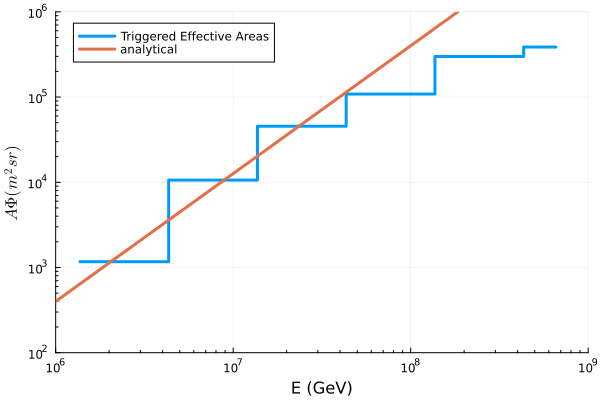

In [79]:
plt = plot(
    xscale=:log,
    yscale=:log,
    xlabel="E (GeV)",
    xminorticks=true,
    yminorticks=true,
    ylabel="\$ A\\Phi (m^{2}sr) \$",
    xlimits=(1e6, 1e9),
    ylimits=(1e2, 1e6),
    legend=:topleft,
    size=(600, 400)   
)

γ = 2.52
norm = 1.8e-18 / units.GeV / units.cm^2 / units.second * (1 /(100units.TeV))^-γ
pl = Tambo.PowerLaw(γ, 100units.GeV, 1e9units.GeV, norm)
fluxes = pl.(triggered_events_three_amigos["initial_state"]["energy"])

label = "Triggered Effective Areas"
hist_three = fit(Histogram, triggered_events_three_amigos["initial_state"]["energy"], Weights(rates_three_amigos./fluxes), edges)
plot!(
    plt,
    cents / units.GeV,
    hist_three.weights ./ diff(edges) ./units.m^2 * (5000/nmodules)*10,
    linetype=:stepmid,
    label=label,
    lw=3
    )
f(x) = 400 * (x/1e15)^1.5

# Generate the data points
y = f.(cents)     # Broadcast the function f over the array x
plot!(plt, cents/units.GeV,y,lw=3,label="analytical")

display(plt)

In [36]:
fluxes

518-element Vector{Float64}:
 2.9655889804647303e-55
 3.6257051941206195e-58
 2.357061591887316e-58
 6.077906194343011e-58
 4.993119493960242e-58
 3.742689416267688e-60
 1.0869488479906267e-60
 1.0451957200126321e-60
 1.9205983339678462e-60
 2.7778728510205357e-58
 2.0120403905874788e-56
 8.637157203996832e-57
 1.345855266412586e-59
 ⋮
 5.4420794142206755e-62
 1.4176928862359666e-61
 7.925152465697505e-61
 2.712329926583701e-57
 3.8403988513336786e-58
 4.131226829420825e-60
 5.102403645548008e-60
 6.636397174696341e-60
 1.5764225113292984e-59
 1.8215159347370552e-55
 3.1857000967691643e-55
 3.4889936638508216e-58

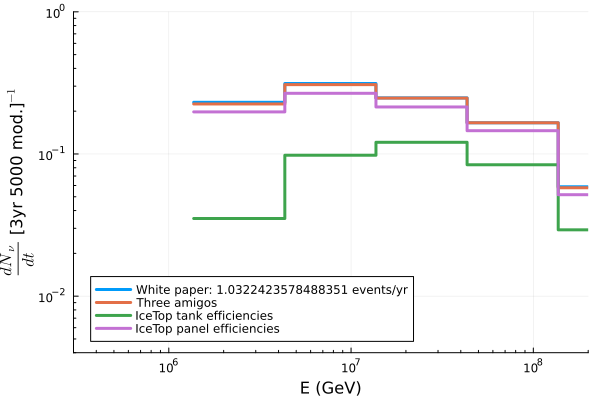

In [19]:
plt = plot(
    xscale=:log,
    yscale=:log,
    xlabel="E (GeV)",
    xminorticks=true,
    yminorticks=true,
    ylabel="\$ \\frac{dN_{\\nu}}{dt}\$ [3yr 5000 mod.]\$^{-1}\$",
    xlimits=(3e5, 2e8),
    ylimits=(4e-3, 1e0),
    legend=:bottomleft,
    size=(600, 400)   
)

nmodules = 400
edges = 10 .^ (14:0.5:18)
cents = (edges[1:end-1] .+ edges[2:end]) / 2

label = "White paper: $(events_per_year_wp) events/yr"
hist_wp = fit(Histogram, triggered_events_white_paper["initial_state"]["energy"], Weights(rates_white_paper), edges)
plot!(
    plt,
    cents / units.GeV,
    hist_wp.weights .* units.second * 3*10^7.5 .* (5_000 / nmodules),
    linetype=:stepmid,
    label=label,
    lw=3
    )

label = "Three amigos"
hist_three = fit(Histogram, triggered_events_three_amigos["initial_state"]["energy"], Weights(rates_three_amigos), edges)
plot!(
    plt,
    cents / units.GeV,
    hist_three.weights .* units.second * 3*10^7.5 .* (5_000 / nmodules),
    linetype=:stepmid,
    label=label,
    lw=3
    )

label = "IceTop tank efficiencies"
hist_it = fit(Histogram, triggered_events_icetop_tanks["initial_state"]["energy"], Weights(rates_icetop_tanks), edges)
plot!(
    plt,
    cents / units.GeV,
    hist_it.weights .* units.second * 3*10^7.5 .* (5_000 / nmodules),
    linetype=:stepmid,
    label=label,
    lw=3
    )

label = "IceTop panel efficiencies"
hist_it = fit(Histogram, triggered_events_icetop_panels["initial_state"]["energy"], Weights(rates_icetop_panels), edges)
plot!(
    plt,
    cents / units.GeV,
    hist_it.weights .* units.second * 3*10^7.5 .* (5_000 / nmodules),
    linetype=:stepmid,
    label=label,
    lw=3
    )

display(plt)

In [8]:
using QuadGK

In [9]:
γ = 2.52
norm = 1.8e-18 / units.GeV / units.cm^2 / units.second * (1 /(100units.TeV))^-γ
pl = Tambo.PowerLaw(γ, 100units.GeV, 1e9units.GeV, norm)

PowerLaw(γ=2.52, emin=100.0 GeV, emax=1.0e9 GeV)

In [10]:
ea_wp = [(hist_wp.weights[i] / quadgk(pl, hist_wp.edges[1][i], hist_wp.edges[1][i+1], rtol=1e-3)[1])*(1/units.m^2) for (i,j) in enumerate(hist_wp.edges[1][1:end-1])]
ea_three = [(hist_three.weights[i] / quadgk(pl, hist_three.edges[1][i], hist_three.edges[1][i+1], rtol=1e-3)[1])*(1/units.m^2) for (i,j) in enumerate(hist_three.edges[1][1:end-1])]
ea_it = [(hist_it.weights[i] / quadgk(pl, hist_it.edges[1][i], hist_it.edges[1][i+1], rtol=1e-3)[1])*(1/units.m^2) for (i,j) in enumerate(hist_it.edges[1][1:end-1])];

LoadError: UndefVarError: `hist_wp` not defined

In [11]:
h_ea_wp = fit(Histogram, log10.(edges[1:end-1]), Weights(110*ea_wp), nbins=10)
plot(h_ea_wp, xlabel = "log(E)", ylabel = "Effective Area m^2 sr",yscale=:log10, yticks= 10.0 .^ collect(range(0,5,step=1)),label="White paper trigger")

h_ea_three = fit(Histogram, log10.(edges[1:end-1]), Weights(110*ea_three), nbins=10)
plot!(h_ea_three, xlabel = "log(E)", ylabel = "Effective Area m^2 sr",yscale=:log10, yticks= 10.0 .^ collect(range(0,5,step=1)),label="Perfect gammas, muons, electrons only")

h_ea_it = fit(Histogram, log10.(edges[1:end-1]), Weights(110*ea_it), nbins=10)
plot!(h_ea_it, xlabel = "log(E)", ylabel = "Effective Area m^2 sr",yscale=:log10, yticks= 10.0 .^ collect(range(0,5,step=1)),label="IceTop tank efficiencies")

E = 15:0.1:17.5
plot!(E, 400*(10 .^E / 1e15).^1.5,yscale=:log10, label="White paper effective area")

plot!(legend=:topleft)

LoadError: UndefVarError: `ea_wp` not defined